In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import itertools

In [37]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [38]:
LATENT_DIM = 2

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Flatten()
    )
    self.fc_mu = nn.Linear(64*7*7, LATENT_DIM)
    self.fc_log_sigma = nn.Linear(64*7*7, LATENT_DIM)

  def forward(self, x):
    h = self.net(x)
    mu = self.fc_mu(h)
    sigma = torch.exp(self.fc_log_sigma(h))
    return dist.Normal(mu, sigma)

class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(LATENT_DIM, 64*7*7),
      nn.Unflatten(1, (64, 7, 7)),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
    )

  def forward(self, z):
    logits = self.net(z)
    return dist.ContinuousBernoulli(logits=logits)

In [ ]:
def elbo(encoder, decoder, x):
  posterior_dist = encoder(x) # q
  z = posterior_dist.rsample()
  likelihood_dist = decoder(z) # p
  prior_dist = dist.Normal(torch.zeros_like(z), torch.ones_like(z))
  
  reconstruction = likelihood_dist.log_prob(x).sum(dim=[1, 2, 3]) 
  kl_term = posterior_dist.log_prob(z).sum(dim=1) - prior_dist.log_prob(z).sum(dim=1)
  
  elbo = reconstruction - kl_term
  return elbo.sum()

In [40]:
encoder = Encoder()
decoder = Decoder()
optimizer = optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=1e-3)

for epoch in range(10):
  total_loss = 0
  for batch_idx, (x, _) in enumerate(train_loader):
    optimizer.zero_grad()
    loss = -elbo(encoder, decoder, x).sum()
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
        
  print(f"Epoch {epoch+1} | Average Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1 | Average Loss: -1348.0157
Epoch 2 | Average Loss: -1479.1208
Epoch 3 | Average Loss: -1501.4822
Epoch 4 | Average Loss: -1515.0556
Epoch 5 | Average Loss: -1523.9062
Epoch 6 | Average Loss: -1529.5019
Epoch 7 | Average Loss: -1533.7282
Epoch 8 | Average Loss: -1537.1637
Epoch 9 | Average Loss: -1539.9947
Epoch 10 | Average Loss: -1542.5620


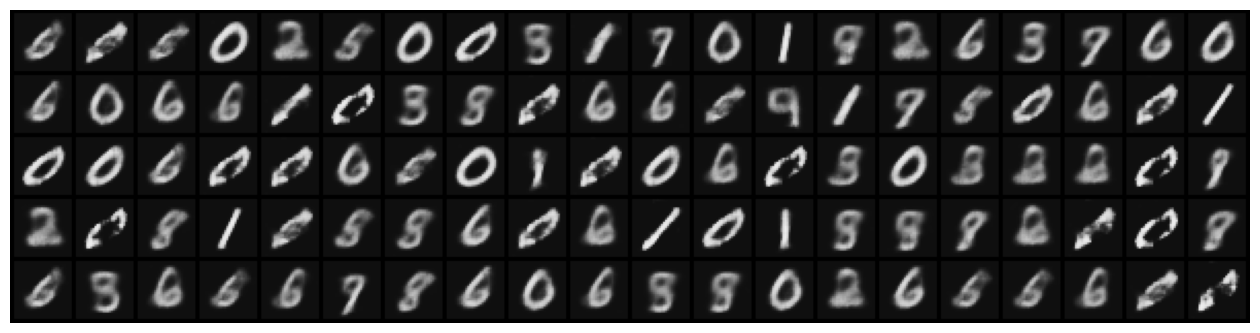

In [ ]:
with torch.no_grad():
    z = torch.randn(100, LATENT_DIM)
    images = decoder(z).mean
    images = images.view(-1, 1, 28, 28)
    grid_img = make_grid(images, nrow=20, padding=2, normalize=False)
        
    plt.figure(figsize=(16, 32))
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()

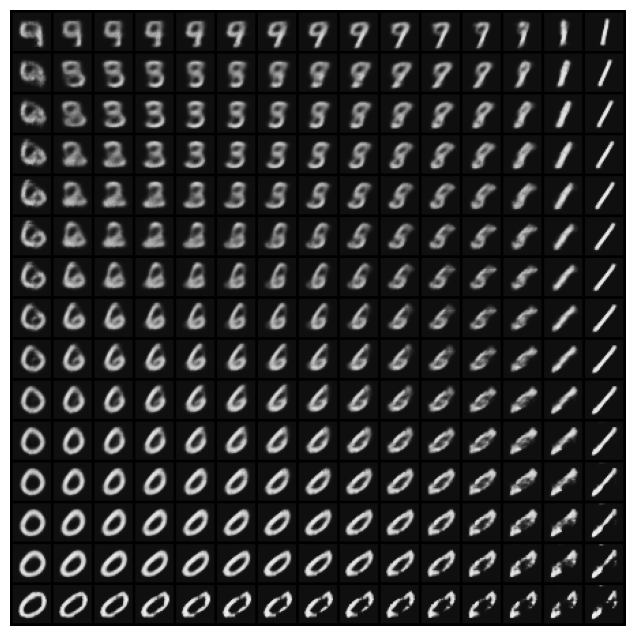

In [74]:
X_random_batch, _ = next(iter(train_loader))
W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
XX, YY = torch.meshgrid(points, points, indexing='ij')
XXYY = torch.stack((XX, YY)).reshape(2, -1).T
with torch.no_grad():
    out = decoder(XXYY @ W).mean
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))
plt.show()